# A Gentle Introduction to Partial Pooled models

In this blog, we'll learn about the partial pooled models and where they are useful. In addition, we'll use PyMC framework to implement a simple partial pooled model.

## A practical example

Lets take a practical example to understand partial pooled models and related variants.

Imagine you are a data scientist tasked with analyzing the academic performance of students across various schools in a city. Each school caters to a unique demographic, with varying resources and teaching methods. Your goal is to estimate the average exam scores of students in different schools. However, you face a challenge – some schools have a large number of students with comprehensive data, while other schools are smaller and have limited data available.

Now lets create some representative data for this task. I'll refer school as a group in some contexts below.

In [1]:
# Necessary imports
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az

from typing import List
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
az.style.use('arviz-darkgrid')

In [2]:
# The total number of schools in the city
num_of_schools = 50

# The number of data samples (students) for each school. 
data_samples_per_school = np.random.randint(2, 100, size=num_of_schools)

# The average performance of students in the city. Lets say the performance is measured out of 100
true_global_mean = 63

# The variation around the global mean, which represents the average performance of students across all schools, follows a normal distribution with a mean of 63 and a standard deviation of 2.
true_global_variability = 2

# The variability in the exam scores within each school
within_school_variability = 10

In [3]:
rng = np.random.default_rng(seed=RANDOM_SEED)

def generate_data(*, num_of_schools: int, data_samples_per_school: List[int], true_global_mean: int, true_global_variability: int, within_school_variability: int):

    # Generate true mean performance for each school around the global mean
    true_school_means = rng.normal(true_global_mean, true_global_variability, num_of_schools)

    # Generate synthetic academic performance data for each school
    data = []
    for school, num_samples in enumerate(data_samples_per_school):

        # Generate data samples for each school around their true mean
        school_data = rng.normal(true_school_means[school], within_school_variability, num_samples)

        # Append data with school index for each generated value
        for value in school_data:
            data.append({'School ID': school, 'score': value})
        
    data = pd.DataFrame(data)
    data.index.name = "Student ID"
    return true_school_means, data

# Create data
true_group_means, data = generate_data(
    num_of_schools=num_of_schools,
    data_samples_per_school=data_samples_per_school,
    true_global_mean=true_global_mean,
    true_global_variability=true_global_variability,
    within_school_variability=within_school_variability
)

# Shuffle data
data = data.sample(frac=1)

data.head()

,School ID,score
Student ID,,
1697,33,64.510645
314,6,62.005591
1786,35,67.453794
1730,35,73.349892
1224,23,56.454934


Here is how the distribution of students in each school looks like:

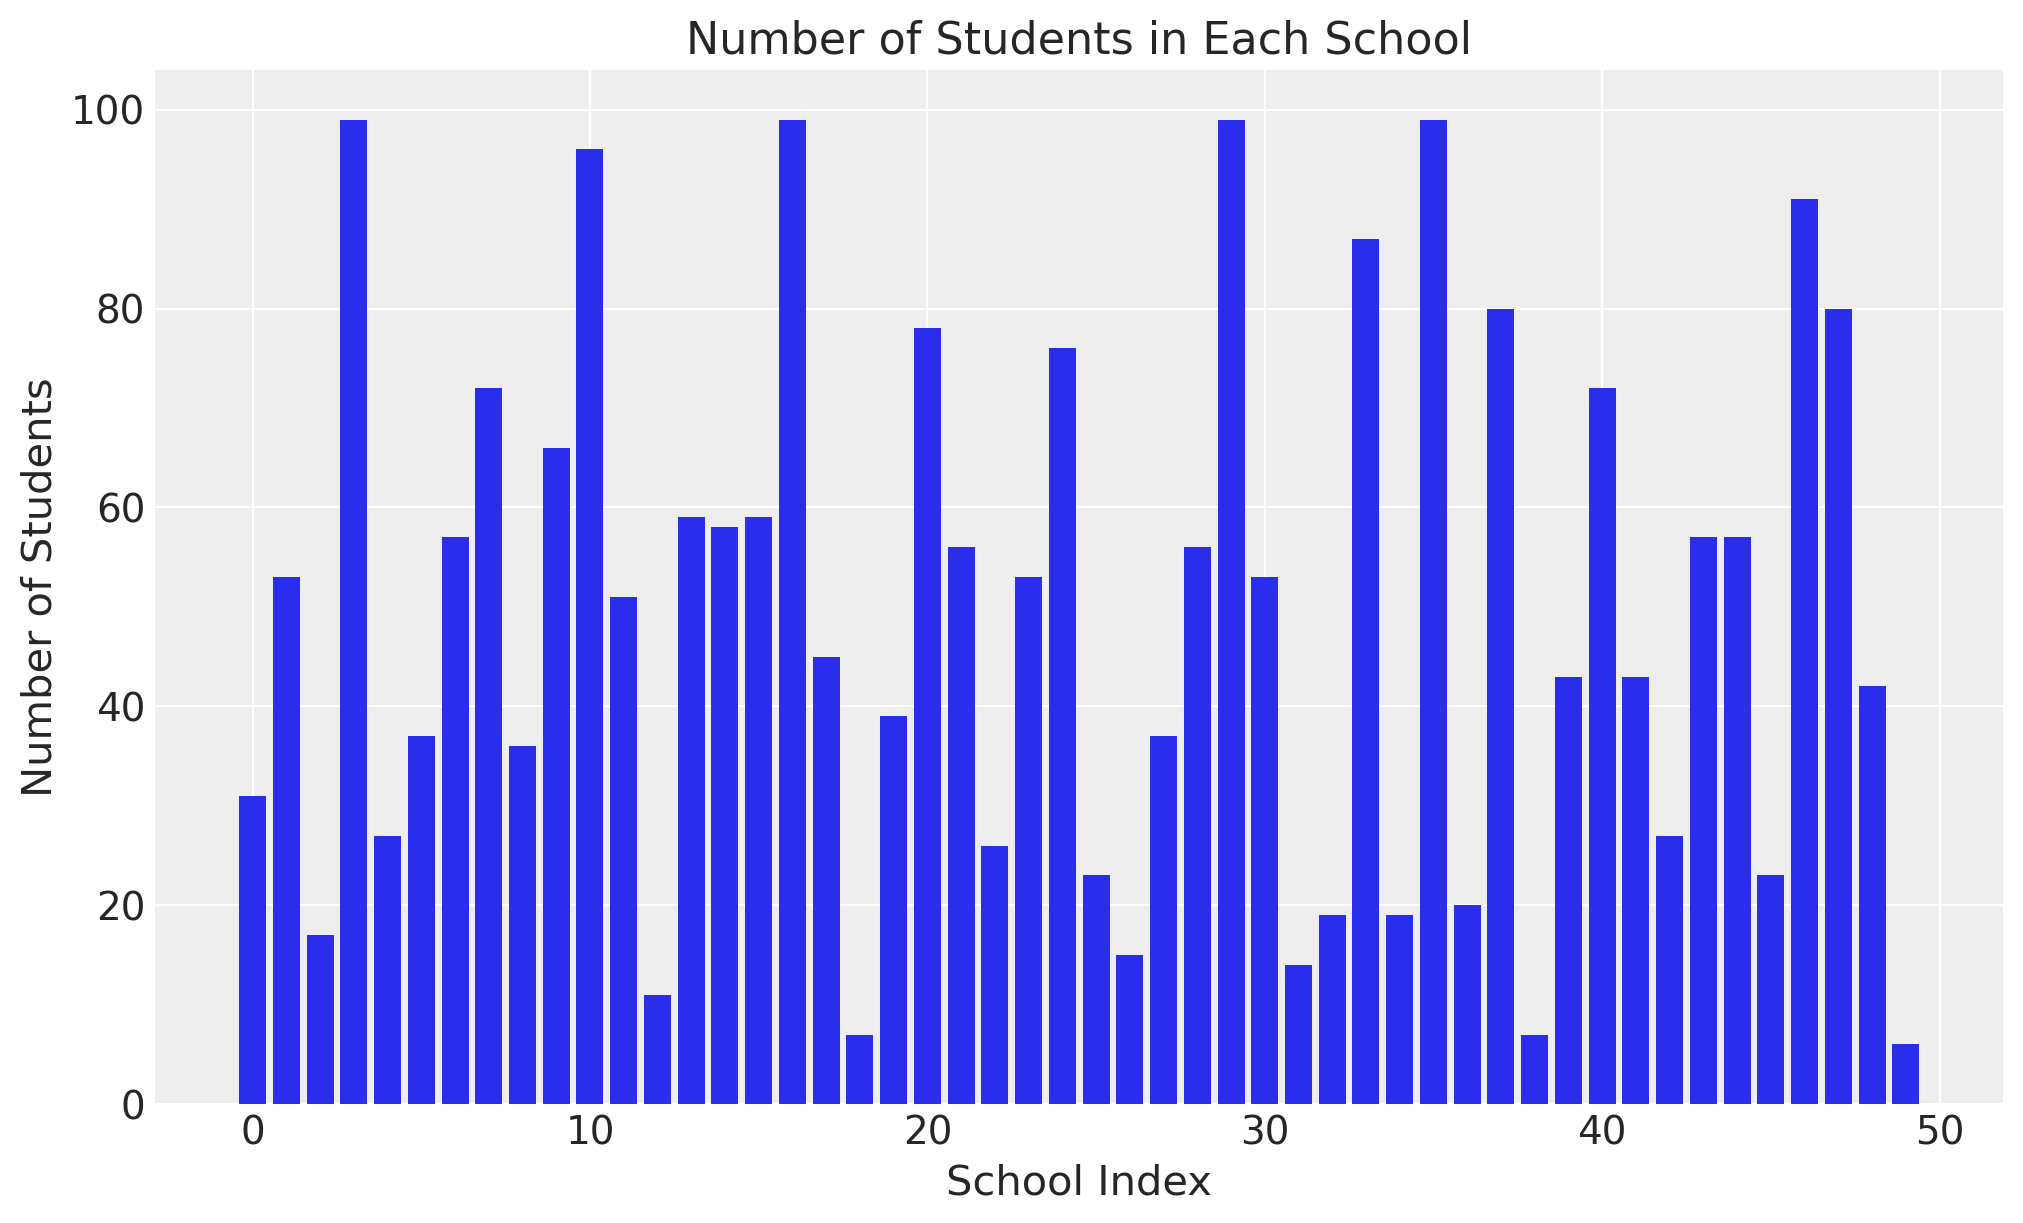

In [4]:
group_counts = data['School ID'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values)

# Add labels and title
plt.xlabel('School Index')
plt.ylabel('Number of Students')
plt.title('Number of Students in Each School')

plt.show();

It can be observed that there are a few schools which has a lot lesser no of students compared to other schools.

Lets also plot the distribution of student's performance scores for first 4 schools, to help us get a glimpse of how the data looks like:

/var/folders/ht/b4r2nlz93qv31tp71vbdb5hm0000gn/T/ipykernel_30691/1436856505.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


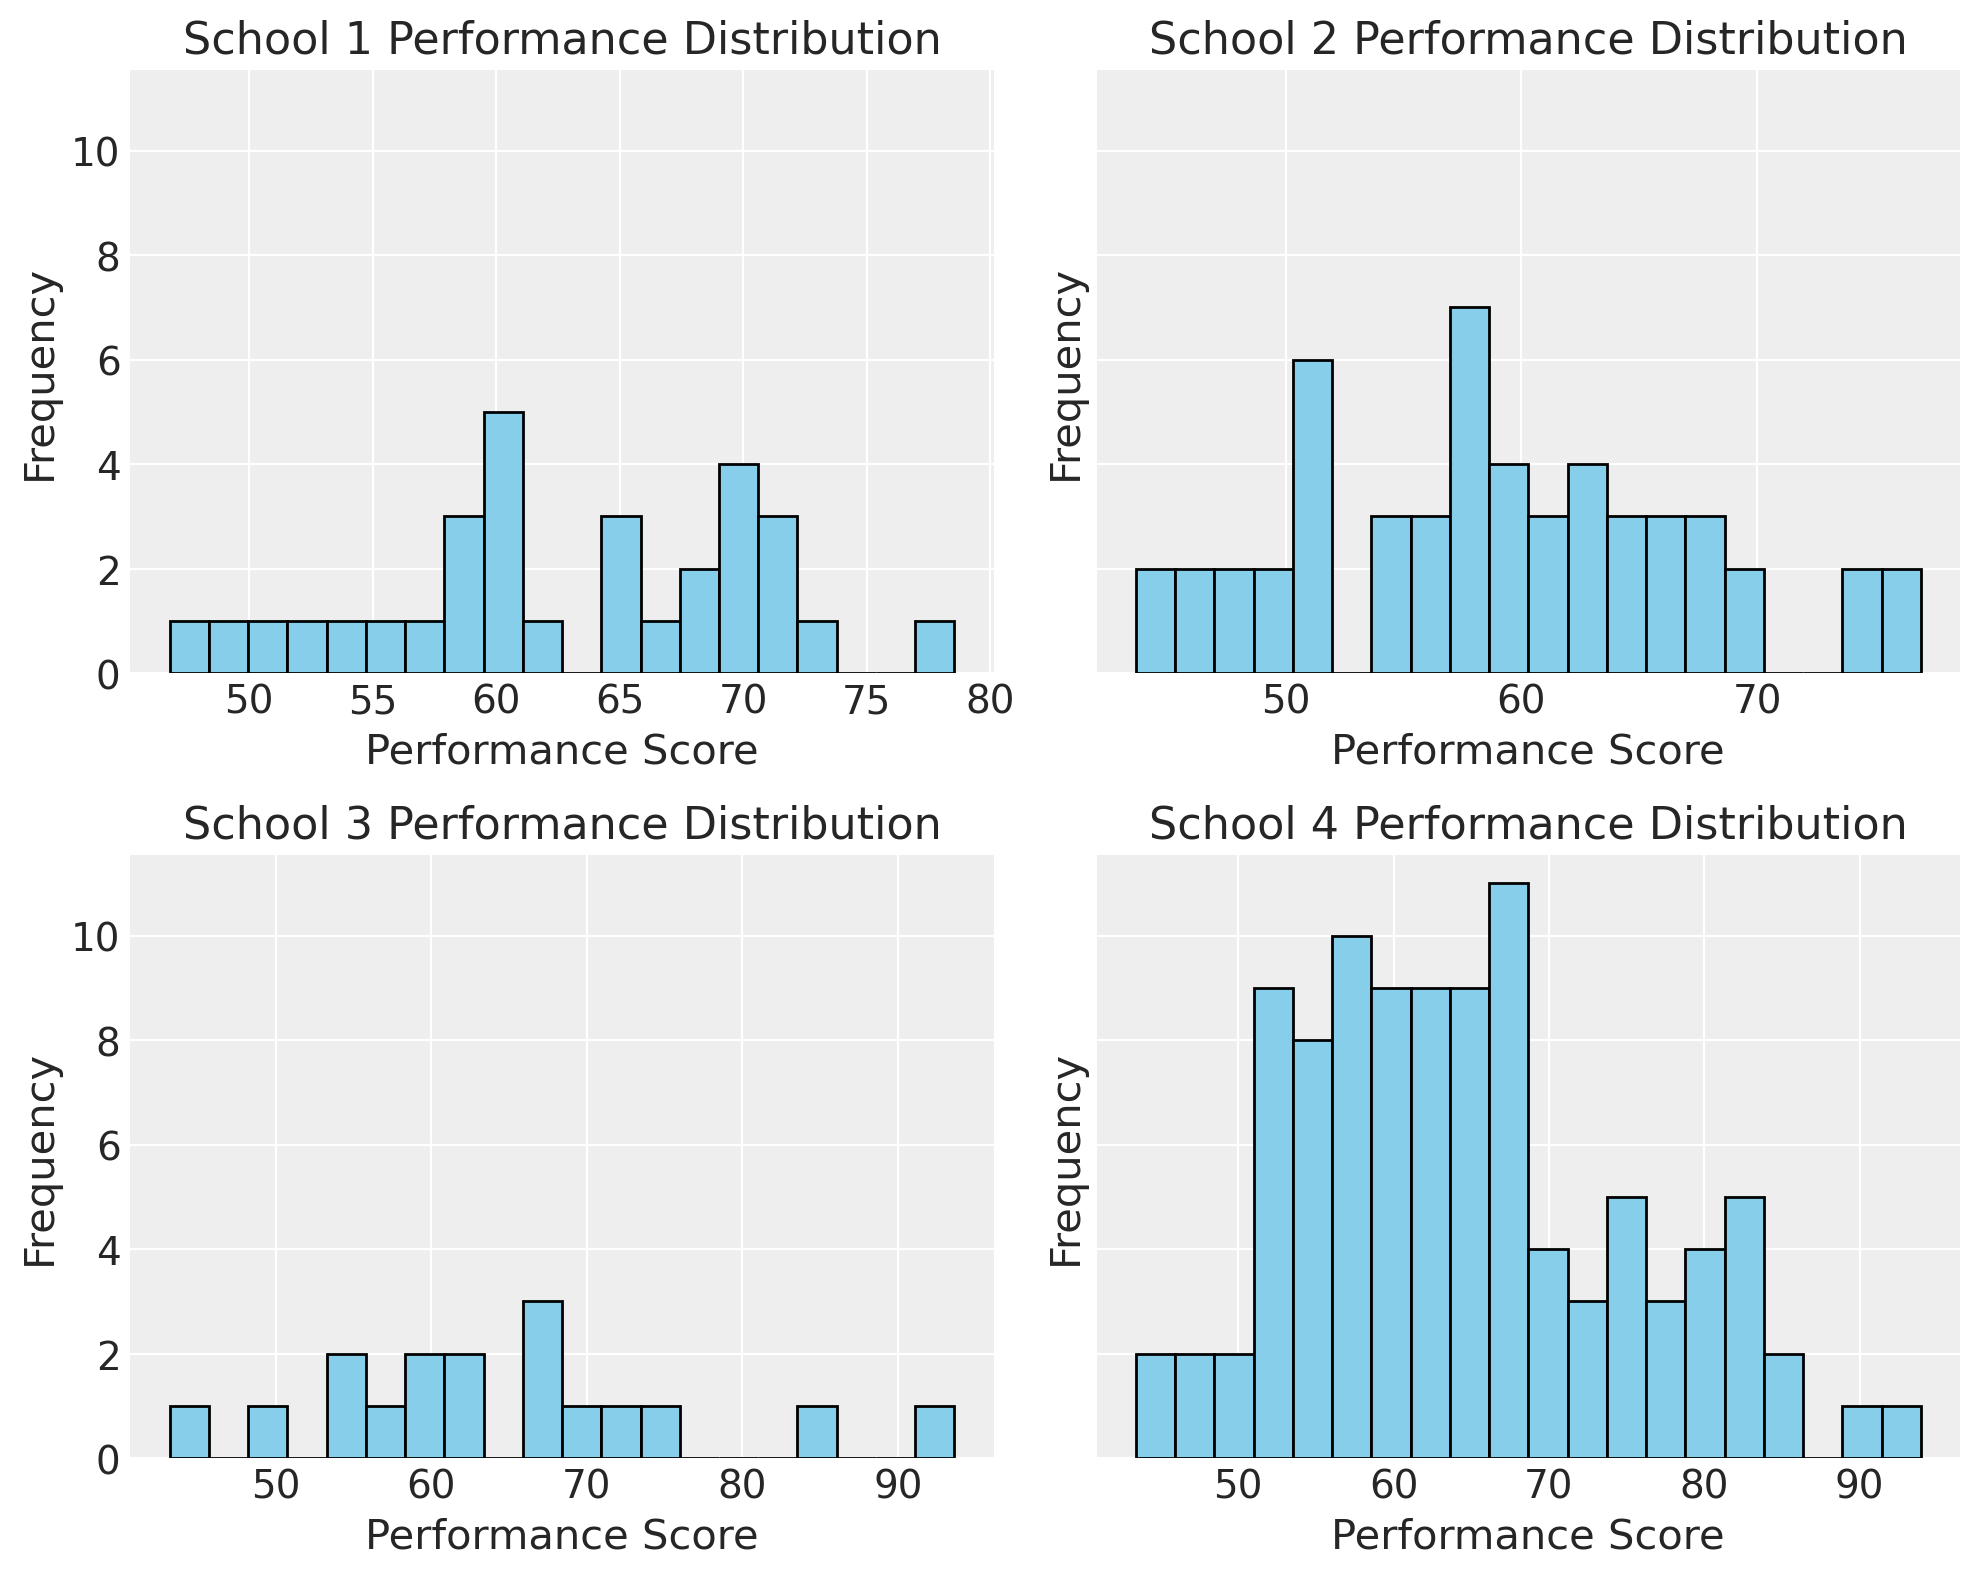

In [5]:
# Set up 2x2 subplots for the first 4 schools
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=True)

# Plot performance scores for each school
for school_index, ax in enumerate(axes.flatten()):
    school_data = data[data['School ID'] == school_index]
    
    ax.hist(school_data['score'], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'School {school_index + 1} Performance Distribution')
    ax.set_xlabel('Performance Score')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show();


There are two approaches to estimate performance of students:

## Unpooled Model

One way is to treat each school as an entirely independent entity. A separate model is fitted for each school, estimating the average exam scores within that specific school. This approach is known as the "no-pooling" or "unpooling" approach, as it refrains from sharing information across schools.

Such a model can be visually represented as:

![Unpooled model](images/unpooled.png)

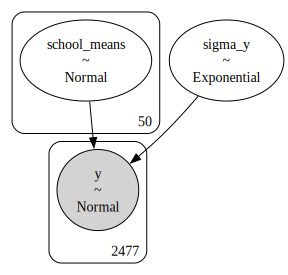

In [6]:
# Here is the implementation of unpooled model in pymc

with pm.Model() as unpooled_model:

    # School specific information
    # We'll assume a reasonable mean of 50 as a prior of city-wide average performance of students
    school_means = pm.Normal("school_means", mu=50, sigma=10, shape=num_of_schools)

    school_idx = data['School ID'].values

    # Model error
    sigma_y = pm.Exponential('sigma_y', 1)

    # Likelihood
    y = pm.Normal("y", mu=school_means[school_idx], sigma=sigma_y, observed=data['score'])

# Plot the graphical structure of the unpooled model
pm.model_to_graphviz(unpooled_model)

In [7]:
# Using MCMC to estimate the model's parameters
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [school_means, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


## Partial pooled model

Other approach to tackle the problem is to define a shared global model to capture the overall patterns in the entire dataset. Each school's model is then allowed to deviate from the global model based on its own data. The extent of this deviation is determined by the amount of data available for each school. This approach is known as the "partial pooling" approach. 

Such a model can be visually represented as:

![Partial Pooled model](images/partial_pool.png)

Equation for estimating group level mean in partially pooled model can be written as:

$$
\hat{\alpha}_{j}^{\text{partial-pooled}} \approx \frac{\frac{n_j}{\sigma_y^2} \bar{y}_j + \frac{1}{\sigma_{\alpha}^2} \bar{y}_{\text{all}}}{\frac{n_j}{\sigma_y^2} + \frac{1}{\sigma_{\alpha}^2}}
$$


- $\hat{\alpha}_{j}^{\text{partial-pooled}}$: The estimated mean for group $j$ in the partial-pooled model.
- $n_j$: The number of observations in group $j$.
- $\bar{y}_j$: The observed mean for group $j$.
- $\sigma_y^2$: The variance within groups.
- $\sigma_{\alpha}^2$: The variance between groups.
- $\bar{y}_{\text{all}}$: The overall observed mean across all groups.

In our example, a school is a group.

Through the equation we can observe that estimates for groups with smaller sample sizes will shrink towards the city-wide average, while those for groups with larger sample sizes will be closer to the unpooled school estimates.



Here is the derivation of the equation: This is the real reason for me writing this blog post, i.e. to share the derivation of group level mean estimates of partially pooled model

<details class="tip">
    <summary>Derivation</summary>
    <p>
    
% Assuming a normal model for the data $y_j$ for group j with a normal prior for the mean $\alpha_j$.

% Let $y_j = N(\alpha_j, \sigma^2_y)$ and $\alpha_j = N(\mu, \sigma^2_{\alpha})$

% The likelihood is given by the normal distribution:
$$
p(y_j | \alpha_j) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(y_j - \alpha_j)^2}{2\sigma^2_y}\right)
$$

% The log likelihood is the logarithm of the above:
$$
\log p(y_j | \alpha_j) = \log\left(\frac{1}{\sqrt{2\pi\sigma^2_y}}\right) -\frac{(y_j - \alpha_j)^2}{2\sigma^2_y}
$$

% Simplifying the constant and assuming a sample size of $n_j$ for group j, i.e. to add log prob terms of all samples as they are i.i.d:
$$
\log p(y_j | \alpha_j) = -\frac{n_j}{2}\log(2\pi\sigma^2_y) -\frac{1}{2\sigma^2_y}\sum_{i=1}^{n_j}(y_{ji} - \alpha_j)^2
$$

% For the prior:
$$
p(\alpha_j) = \frac{1}{\sqrt{2\pi\sigma^2_\alpha}} \exp\left(-\frac{(\alpha_j - \mu)^2}{2\sigma^2_\alpha}\right)
$$

% The log prior is the logarithm of the above:
$$
\log p(\alpha_j) = \log\left(\frac{1}{\sqrt{2\pi\sigma^2_\alpha}}\right) -\frac{(\alpha_j - \mu)^2}{2\sigma^2_\alpha}
$$

% Simplifying the constant:
$$
\log p(\alpha_j) = -\frac{1}{2}\log(2\pi\sigma^2_\alpha) -\frac{1}{2\sigma^2_\alpha}(\alpha_j - \mu)^2
$$

% Now, combining the log likelihood and the log prior for the log posterior:
$$
\log p(\alpha_j | y_j) \propto -\frac{n_j}{2}\log(2\pi\sigma^2_y) -\frac{1}{2\sigma^2_y}\sum_{i=1}^{n_j}(y_{ji} - \alpha_j)^2 -\frac{1}{2}\log(2\pi\sigma^2_\alpha) -\frac{1}{2\sigma^2_\alpha}(\alpha_j - \mu)^2
$$

% Taking the derivative of the log posterior with respect to $\alpha_j$, setting it to zero, and solving for $\alpha_j$ will yield the MAP estimate.

% Continuing from the log posterior, we have:
$$
\log p(\alpha_j | y_j) \propto -\frac{1}{2\sigma^2_y}\sum_{i=1}^{n_j}(y_{ji} - \alpha_j)^2 -\frac{1}{2\sigma^2_\alpha}(\alpha_j - \mu)^2
$$

% The derivative of the log posterior with respect to alpha_j is:
$$
\frac{d}{d\alpha_j}\log p(\alpha_j | y_j) = \frac{1}{\sigma^2_y}\sum_{i=1}^{n_j}(y_{ji} - \alpha_j) - \frac{1}{\sigma^2_\alpha}(\alpha_j - \mu)
$$

% Setting the derivative to zero for the MAP estimate:
$$
\frac{1}{\sigma^2_y}\sum_{i=1}^{n_j}(y_{ji} - \alpha_j) - \frac{1}{\sigma^2_\alpha}(\alpha_j - \mu) = 0
$$

% Solving for alpha_j gives us:
$$
\frac{1}{\sigma^2_y}\sum_{i=1}^{n_j}y_{ji} - \frac{n_j}{\sigma^2_y}\alpha_j - \frac{1}{\sigma^2_\alpha}\alpha_j + \frac{\mu}{\sigma^2_\alpha} = 0
$$

% Collect terms involving alpha_j:
$$
\left(\frac{n_j}{\sigma^2_y} + \frac{1}{\sigma^2_\alpha}\right)\alpha_j = \frac{1}{\sigma^2_y}\sum_{i=1}^{n_j}y_{ji} + \frac{\mu}{\sigma^2_\alpha}
$$

% Since $\sum_{i=1}^{n_j}y_{ji}$ is just $n_j$ times the sample mean $\bar{y}_j$:
$$
\left(\frac{n_j}{\sigma^2_y} + \frac{1}{\sigma^2_\alpha}\right)\alpha_j = \frac{n_j}{\sigma^2_y}\bar{y}_j + \frac{\mu}{\sigma^2_\alpha}
$$

% Divide through by the coefficient of $\alpha_j$ to solve for it:
$$
\alpha_j = \frac{\frac{n_j}{\sigma^2_y}\bar{y}_j + \frac{\mu}{\sigma^2_\alpha}}{\frac{n_j}{\sigma^2_y} + \frac{1}{\sigma^2_\alpha}}
$$

% If we let $\mu = \bar{y}_{\text{all}}$, we get the original equation provided:
$$
\hat{\alpha}_{j}^{\text{partial-pooled}} \approx \frac{\frac{n_j}{\sigma^2_y}\bar{y}_j + \frac{1}{\sigma^2_\alpha}\bar{y}_{\text{all}}}{\frac{n_j}{\sigma^2_y} + \frac{1}{\sigma^2_\alpha}}
$$

</p>
</details>


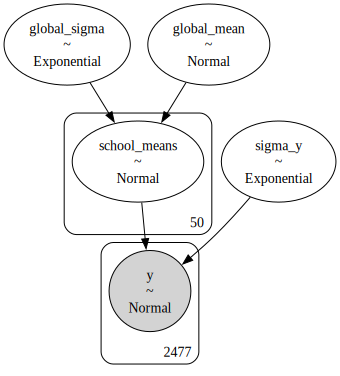

In [8]:
# Lets code it up in PyMC:

with pm.Model() as partially_pooled_model:
    # Global parameters
    global_mean = pm.Normal("global_mean", 50, sigma=10)
    global_sigma = pm.Exponential("global_sigma", 1)

    # School specific information
    school_means = pm.Normal("school_means", global_mean, global_sigma, shape=num_of_schools)

    school_idx = data['School ID'].values

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Likelihood
    y = pm.Normal("y", school_means[school_idx], sigma_y, observed=data['score'])

# Plot the graphical structure of the partial pooled model
pm.model_to_graphviz(partially_pooled_model)

In [9]:
with partially_pooled_model:
    partially_pooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mean, global_sigma, school_means, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.


## Comparison

Lets compare the average estimates of student's performance in different schools computed in both approaches:

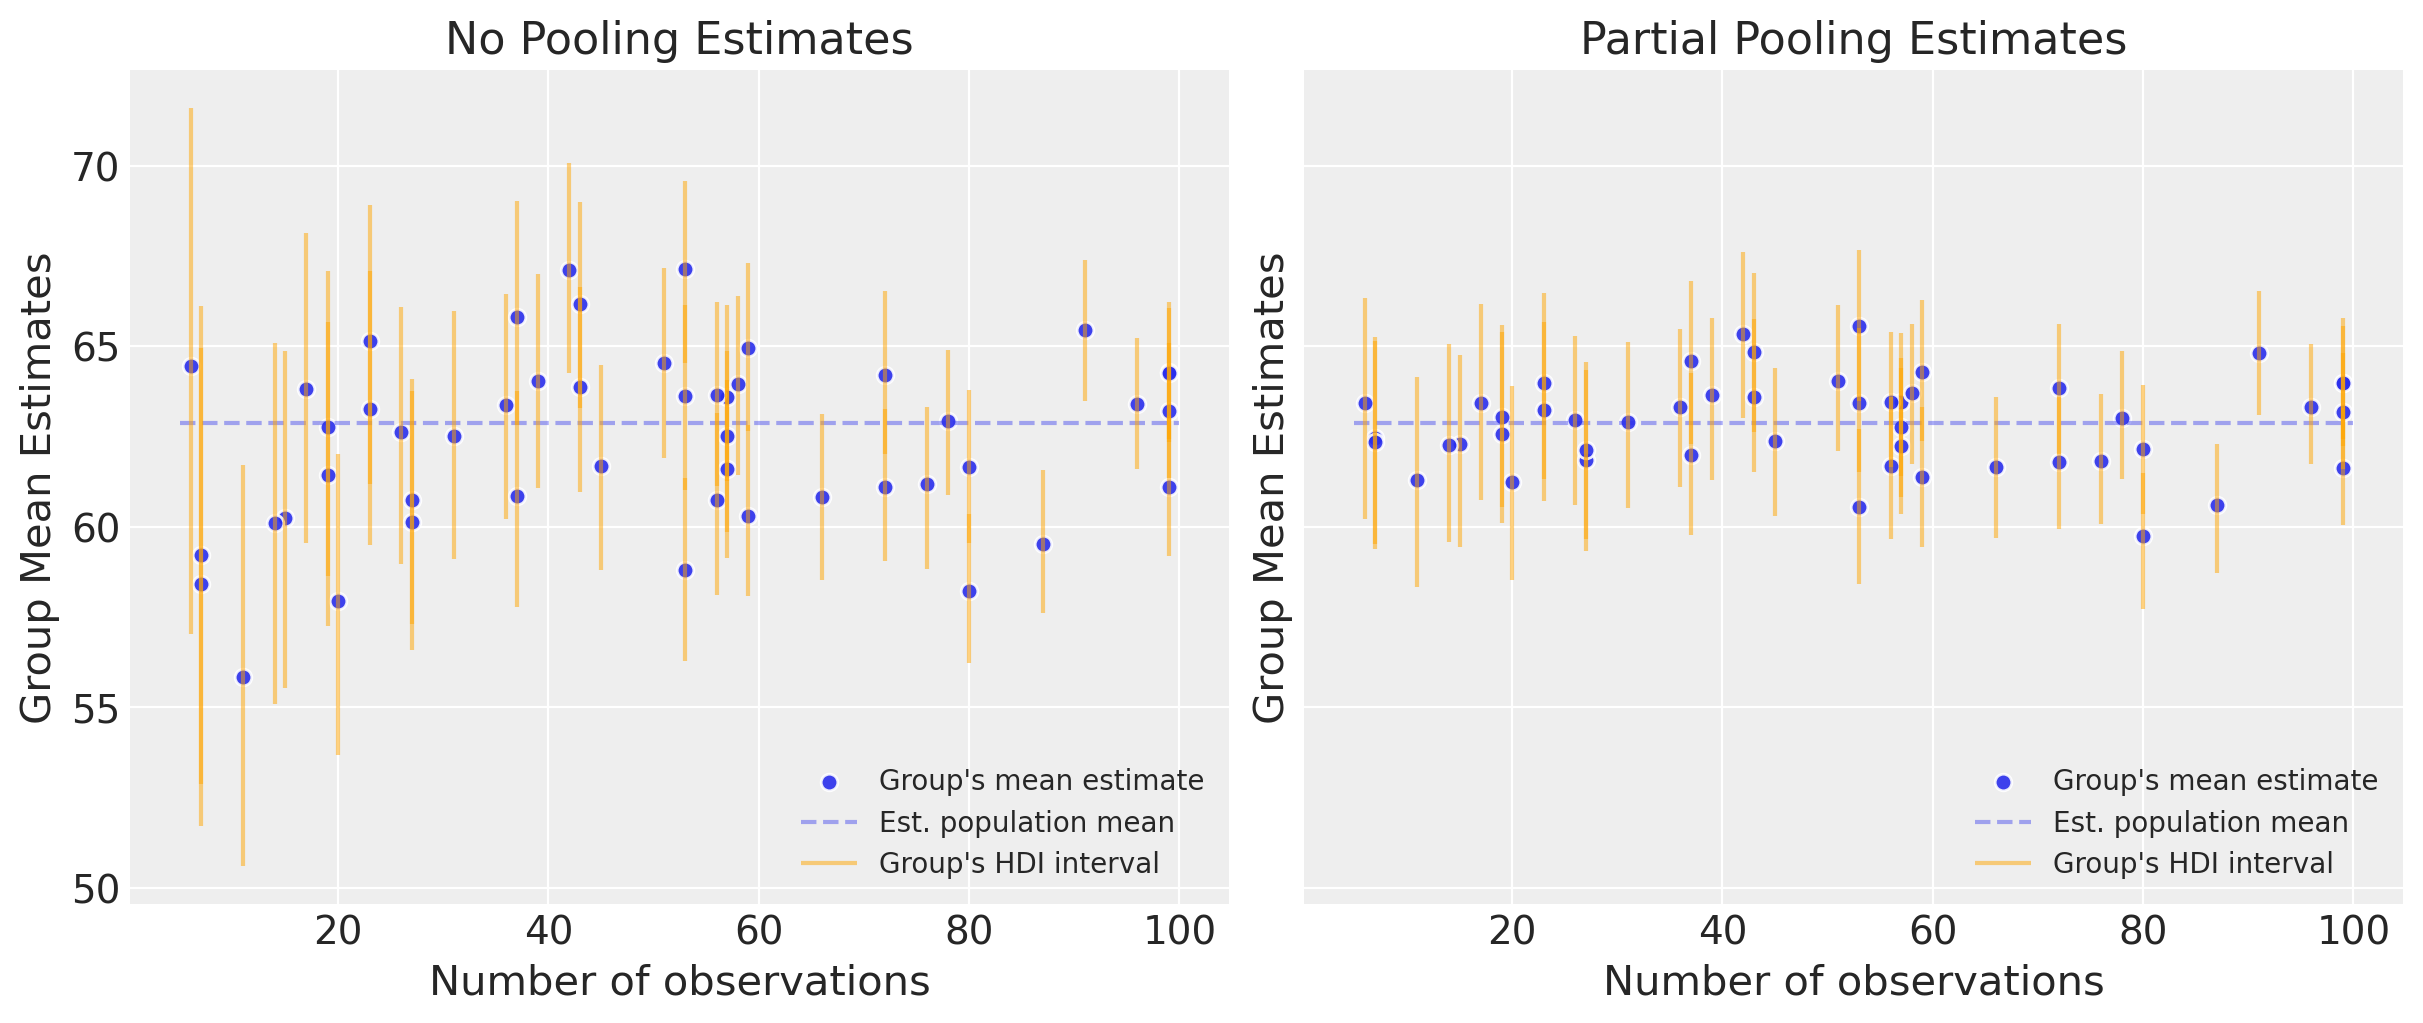

In [10]:
num_observations = data_samples_per_school
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partially_pooled_trace),
    ("no pooling", "partial pooling"),
):
    trace.posterior = trace.posterior.assign_coords({"num_observations": ("school_means_dim_0", num_observations)})

    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="num_observations", y="school_means", ax=ax, alpha=0.9, label="Group's mean estimate"
    )
    ax.hlines(
        partially_pooled_trace.posterior.school_means.mean(),
        min(num_observations) - 1,
        max(num_observations) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).school_means
    ax.vlines(num_observations, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5, label="Group's HDI interval")

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Number of observations",
        ylabel="Group Mean Estimates",
    )
    ax.legend(fontsize=10, loc='lower right')

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. In the partially-pooled model, estimates in small-sample-size counties are informed by the population parameters – hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) – hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in counties where data is sparse.

## Key takeaways
- The "partial pooling" approach seeks a balance between treating each group entirely independently and pooling all data together. It introduces a hierarchical structure to the modeling, allowing information sharing between groups.
- This approach is particularly useful when dealing with groups of different sizes, as it allows smaller groups to borrow strength from the overall trends observed in the larger dataset.

## References
- Used ChatGPT for generating data, and equations.
- [Multilevel modelling guide in PyMC](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html)
- Andrew Gelman and Jennifer Hill. Data analysis using regression and multilevel/hierarchical models. Cambridge university press, 2006. 

Thank you for reading!

With &#x2764;,
Sayam